
Here is the implementation of the image processing pipeline on ROS. The following steps were carried out using a single BEV image obtained from the Inverse Perspective Mapping (after tuning the IPM). These steps also provide detailed insights for debugging and parameter tuning:

* **BEV Input** – base image after IPM tuning
* **ROI Masking** – restrict processing to lane-relevant region
* **Color Thresholding (HSV) + Morphology** – extract lane pixels, remove noise
* **Sobel X Gradient** – compute edge weights for lane boundary emphasis
* **Sliding Window Search** – detect lane pixels, apply quadratic fit for curvature estimation (R)
* **Centerline & Deviation** – calculate lateral offset and steering-induced shift → total deviation
* **Drive Command Computation** – steering angle & speed derived from deviation using controller
* **Actuation** – final commands sent to the vehicle

![Image Processing Pipeline: From BEV Input to Vehicle Actuation](./data/5.png)

In the upcoming cells, each stage of this procedure is presented in detail for inspection, debugging, and parameter tuning.



## Environment & requirements

Python 3.8+, packages:
- numpy
- opencv-python
- matplotlib
- pyyaml (only if using YAML)

Install with:
```
pip install numpy opencv-python matplotlib pyyaml
```


### 1. Parameters

In [91]:
# ============================================================
# Lane Detection Pipeline Parameters
# ============================================================
# This block defines all important parameters for the image
# processing and lane detection pipeline. These parameters
# correspond to what will later be configured in `lane.yaml`.
# They control aspects such as:
#   - Input image and resizing
#   - ROI masking
#   - HSV color thresholding and morphological filtering
#   - Sobel edge detection
#   - Sliding window search and polynomial fitting
#   - Lane centerline, lookahead region, and deviation estimation
#   - Output directory for saving results
#
# Each parameter will be described in detail in the following
# cells when relevant for debugging, visualization, or tuning.
# ============================================================


PARAMS = {
    'target_width': 640,
    'target_height': 640,
    'input_path': './data/000040.jpg',            # set to 'path/to/your/image.jpg' or None to use synthetic image
    'roi_poly_norm': [(0.15,0.80),(0.70,0.80),(0.70,0.20),(0.15,0.20)],
    'hsv_lower': (2, 50, 80),
    'hsv_upper': (25, 255, 255),
    'morph_kernel': 5,
    'morph_iterations': 1,
    'sobel_ksize': 3,
    'sobel_percentile': 90,
    'sobel_fixed_thresh': 20,
    'alpha_color': 0.83,
    'beta_sobel': 0.17,
    'fusion_threshold': 0.18,
    'win_count': 10,
    'win_half_width': 35,
    'win_min_pixels': 10,
    'win_start_y': 510,
    'win_end_y': 256,
    'poly_degree': 2,
    'lookahead_xmin': 305,
    'lookahead_xmax': 335,
    'lookahead_ymin': 200,
    'lookahead_ymax': 480,
    'hist_peak_min_value': 5,
    'min_lane_distance': 140,
    'min_win_half': 8,
    'center_point_count': 12,
    'strip_min_points': 10,
    'output_dir': 'outputs'
}

import os
os.makedirs(PARAMS['output_dir'], exist_ok=True)
print('PARAMS set. Edit this block to change pipeline behavior.')

PARAMS set. Edit this block to change pipeline behavior.


<!-- # ## Environment & requirements
#
# Python 3.8+, packages:
# - numpy
# - opencv-python
# - matplotlib
# - pyyaml (only if using YAML)
#
# Install with:
# ```
# pip install numpy opencv-python matplotlib pyyaml
# ``` -->


## 2. Helper Functions  

This section defines a set of utility functions that are used throughout the image processing pipeline.  
They support common operations such as visualization, masking, thresholding, and curve fitting.  
By defining them here, we can keep the main pipeline code cleaner and focus on the step-by-step logic.  


In [92]:
from typing import Tuple, List, Optional, Dict, Any
import cv2, numpy as np, os, math

def get_input_image(params: Dict[str, Any]) -> np.ndarray:
    """Load an input image (BGR). If no path is provided, generate a synthetic example."""
    W = params['target_width']; H = params['target_height']
    path = params.get('input_path', None)
    if path and os.path.exists(path):
        img = cv2.imread(path)
        return cv2.resize(img, (W,H), interpolation=cv2.INTER_LINEAR)
    # synthetic fallback
    return synthetic_birdseye(W, H, curvature=0.0008)

def resize_img(img: np.ndarray, params: Dict[str, Any]) -> np.ndarray:
    return cv2.resize(img, (params['target_width'], params['target_height']), interpolation=cv2.INTER_LINEAR)

def build_roi_mask_from_norm(poly_norm: List[Tuple[float,float]], W:int, H:int) -> Tuple[np.ndarray, np.ndarray]:
    pts = []
    for x,y in poly_norm:
        pts.append([int(x*W), int(y*H)])
    mask = np.zeros((H, W), dtype=np.uint8)
    cv2.fillPoly(mask, [np.array(pts, dtype=np.int32)], 255)
    return mask, np.array(pts, dtype=np.int32)

def synthetic_birdseye(w=640, h=640, curvature=0.0008) -> np.ndarray:
    img = np.zeros((h, w, 3), dtype=np.uint8) + 40
    ys = np.linspace(0, h-1, h).astype(int)
    cx = w//2; lane_offset = int(0.22*w)
    left_pts=[]; right_pts=[]
    for y in ys:
        dx = int(curvature * (y - h/2)**2)
        left_pts.append((cx - lane_offset + dx, y)); right_pts.append((cx + lane_offset + dx, y))
    cv2.polylines(img, [np.array(left_pts, dtype=np.int32)], False, (10,120,120), thickness=6)
    cv2.polylines(img, [np.array(right_pts, dtype=np.int32)], False, (10,120,120), thickness=6)
    return img

def hsv_lane_mask(img_bgr: np.ndarray, lower: Tuple[int,int,int], upper: Tuple[int,int,int], morph_k:int=5, morph_iter:int=1) -> Tuple[np.ndarray, np.ndarray]:
    """Return (mask (0/255 uint8), hsv image)."""
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)
    lower_np = np.array(lower, dtype=np.uint8); upper_np = np.array(upper, dtype=np.uint8)
    mask = cv2.inRange(hsv, lower_np, upper_np)
    k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (morph_k, morph_k))
    if morph_iter>0:
        mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, k, iterations=morph_iter)
        mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k, iterations=morph_iter)
    return mask, hsv

def sobel_x_magnitude(img_bgr: np.ndarray, ksize: int=3) -> np.ndarray:
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY).astype(np.float32)
    sx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=ksize)
    return np.abs(sx)

def normalize_to_8u(arr: np.ndarray) -> np.ndarray:
    arr = arr.astype(np.float32); mx = arr.max() if arr.max()>0 else 1.0
    return np.clip((arr/mx)*255.0,0,255).astype(np.uint8)

def to_nonzero_xy(mask: np.ndarray) -> np.ndarray:
    """Return Nx2 int array of (x,y) for nonzero mask pixels (mask is 0/255 uint8)."""
    nz = cv2.findNonZero(mask)
    if nz is None: return np.zeros((0,2), dtype=int)
    return np.array([[int(p[0][0]), int(p[0][1])] for p in nz], dtype=int)



def compute_base_anchors_from_binary(final_binary: np.ndarray,
                                     hist_peak_min_value: float,
                                     min_lane_distance: int,
                                     win_half_width: int,
                                     bottom_frac: float = 1.0/3.0,
                                     morph_kernel: int = 5,
                                     morph_iters: int = 1,
                                     debug: bool = False,
                                     adapt_threshold_if_too_high: bool = True):
    """
    Compute left/right base x anchors and presence flags using only final_binary.
    final_binary: uint8 binary image with values {0,1} or {0,255}.
    hist_peak_min_value:
        - if 0 < value <= 1: interpreted as fraction of bottom window height (recommended),
        - else interpreted as absolute pixel count (0..rb_h).
    min_lane_distance: minimum expected separation between lanes (pixels).
    win_half_width: half-width for smoothing window (kernel size = 2*win_half_width+1, min 3).
    bottom_frac: portion of image height to use from the bottom (default 1/3).
    morph_kernel: if >0, apply morphological open+close with this kernel size to reduce noise.
    morph_iters: number of morphology iterations.
    Returns: ( (left_x, right_x), (useLeft, useRight) )
    """
    # normalize binary to 0/1
    if final_binary.dtype != np.uint8:
        final_binary = final_binary.astype(np.uint8)
    fb = final_binary.copy()
    # if values are 0/255 -> convert to 0/1
    if fb.max() > 1:
        fb = (fb > 0).astype(np.uint8)

    h, w = fb.shape[:2]

    # sanitize bottom_frac
    bottom_frac = float(bottom_frac)
    if bottom_frac <= 0 or bottom_frac > 1:
        bottom_frac = 1.0/3.0

    rb_h = max(10, int(np.clip(h * bottom_frac, 1, h)))  # bottom region height to use
    bottom = fb[h - rb_h : h, :]  # shape (rb_h, w)

    # optional morphological denoise (helps in noisy binarizations)
    if morph_kernel and morph_kernel > 1:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (morph_kernel, morph_kernel))
        bottom = cv2.morphologyEx(bottom.astype(np.uint8), cv2.MORPH_OPEN, k, iterations=morph_iters)
        bottom = cv2.morphologyEx(bottom, cv2.MORPH_CLOSE, k, iterations=morph_iters)

    # column counts (units: pixels in bottom window)
    colcount = bottom.sum(axis=0).astype(float)  # range [0, rb_h]

    # smoothing kernel: ensure odd kernel size at least 3
    if win_half_width <= 0:
        kernel_size = 3
    else:
        kernel_size = max(3, 2 * int(win_half_width) + 1)
    kernel = np.ones(kernel_size, dtype=float) / kernel_size
    smoothv = np.convolve(colcount, kernel, mode='same')

    mid = w // 2
    left_region = smoothv[:mid] if mid > 0 else np.array([])
    right_region = smoothv[mid:] if mid > 0 else np.array([])

    bestL = int(np.argmax(left_region)) if left_region.size else -1
    bestR = (int(np.argmax(right_region)) + mid) if right_region.size else -1

    maxL = float(smoothv[bestL]) if bestL >= 0 else 0.0
    maxR = float(smoothv[bestR]) if bestR >= 0 else 0.0
    overall_max = float(smoothv.max()) if smoothv.size else 0.0

    # interpret threshold
    if 0 < hist_peak_min_value <= 1.0:
        thresh = hist_peak_min_value * rb_h
    else:
        thresh = float(hist_peak_min_value)

    # adapt threshold if user supplied ridiculous value
    if adapt_threshold_if_too_high and overall_max > 0 and thresh > overall_max:
        old_thresh = thresh
        thresh = max(1.0, 0.5 * overall_max)
        if debug:
            print(f"[threshold adapt] supplied {old_thresh:.2f} > observed max {overall_max:.2f}; lowered to {thresh:.2f}")

    useLeft = (bestL >= 0) and (maxL >= thresh)
    useRight = (bestR >= 0) and (maxR >= thresh)

    # if both detected but too close, keep the stronger one
    if useLeft and useRight and (bestR - bestL) < min_lane_distance:
        if maxL > maxR:
            useRight = False
        else:
            useLeft = False

    if debug:
        print("---- compute_base_anchors_from_binary debug ----")
        print(f"image w,h: {w},{h}   bottom_frac: {bottom_frac}   rb_h: {rb_h}")
        print(f"kernel_size: {kernel_size}")
        print(f"bestL: {bestL}  maxL (smoothed count): {maxL:.2f}")
        print(f"bestR: {bestR}  maxR (smoothed count): {maxR:.2f}")
        print(f"overall_max: {overall_max:.2f}  thresh: {thresh:.2f}")
        if bestL >= 0:
            lslice = smoothv[max(0, bestL-3): min(w, bestL+4)]
            print(f"left neigh (idx {max(0,bestL-3)}..{min(w,bestL+4)-1}): {lslice}")
        if bestR >= 0:
            rslice = smoothv[max(0, bestR-3): min(w, bestR+4)]
            print(f"right neigh (idx {max(0,bestR-3)}..{min(w,bestR+4)-1}): {rslice}")
        print(f"useLeft: {useLeft}  useRight: {useRight}")
        print("-----------------------------------------------")

    # fallback anchors if neither present
    if not useLeft and not useRight:
        halfsep = max(1, min(w // 4, min_lane_distance // 2))
        l0 = max(0, mid - halfsep)
        r0 = min(w - 1, mid + halfsep)
        return (l0, r0), (False, False)

    # both found
    if useLeft and useRight:
        return (bestL, bestR), (True, True)

    # only left
    if useLeft:
        bestR_est = min(w - 1, bestL + min_lane_distance)
        return (bestL, bestR_est), (True, False)

    # only right
    bestL_est = max(0, bestR - min_lane_distance)
    return (bestL_est, bestR), (False, True)



def sliding_windows_from_mask(mask: np.ndarray, nonzero_pts: np.ndarray, baseX: Tuple[int,int], config: Dict[str,Any]):
    h,w = mask.shape[:2]
    win_count = config['win_count']
    win_start = config['win_start_y']; win_end = config['win_end_y']
    if win_start <= win_end:
        win_start = h-1; win_end = int(h/4)
    vertical_span = max(1, win_start - win_end)
    win_h = max(1, vertical_span // max(1, win_count))
    win_y_low = []; win_y_high = []
    for i in range(win_count):
        low = int(max(0, win_start - (i+1)*win_h + 1))
        high = int(min(h-1, win_start - i*win_h))
        win_y_low.append(low); win_y_high.append(high)
    nonzero = nonzero_pts
    window_centroids = {0: [], 1: []}
    lane_idxs = {0: [], 1: []}
    currX = [int(baseX[0]), int(baseX[1])]
    for level in range(win_count):
        ylow = win_y_low[level]; yhigh = win_y_high[level]
        cy = (ylow + yhigh)//2
        candidates = []
        for seed_side in [0,1]:
            winHalf = max(config['min_win_half'], config['win_half_width'])
            xcenter = currX[seed_side]
            xlow = max(0, xcenter - winHalf); xhigh = min(w-1, xcenter + winHalf)
            if nonzero.size == 0: continue
            mask_idx = np.where((nonzero[:,1] >= ylow) & (nonzero[:,1] <= yhigh) & (nonzero[:,0] >= xlow) & (nonzero[:,0] <= xhigh))[0]
            if mask_idx.size == 0: continue
            xs = nonzero[mask_idx,0]
            if xs.size >= config['win_min_pixels']:
                newX = int(np.round(xs.mean()))
                candidates.append({'seed': seed_side, 'idxs': mask_idx.tolist(), 'newX': newX, 'weight': xs.size})
        if len(candidates) == 0:
            window_centroids[0].append((currX[0], cy)); window_centroids[1].append((currX[1], cy))
            continue
        if len(candidates) == 1:
            cand = candidates[0]
            side = cand['seed']
            lane_idxs[side].extend(cand['idxs'])
            currX[side] = cand['newX']
            window_centroids[side].append((currX[side], cy))
            window_centroids[1-side].append((currX[1-side], cy))
            continue
        centers = [currX[0], currX[1]]
        for it in range(6):
            groups = {0: [], 1: []}
            for i,c in enumerate(candidates):
                d0 = abs(c['newX'] - centers[0]); d1 = abs(c['newX'] - centers[1])
                assign = 0 if d0 <= d1 else 1
                groups[assign].append(c)
            new_centers = []
            for g in [0,1]:
                if len(groups[g])==0:
                    new_centers.append(centers[g])
                else:
                    s = sum([t['newX']*t['weight'] for t in groups[g]]); wtot = sum([t['weight'] for t in groups[g]])
                    new_centers.append(int(round(s/wtot)))
            centers = new_centers
        clustered = {0: {'idxs':[],'cx':centers[0]}, 1:{'idxs':[],'cx':centers[1]}}
        for i,c in enumerate(candidates):
            d0 = abs(c['newX'] - centers[0]); d1 = abs(c['newX'] - centers[1])
            assign = 0 if d0 <= d1 else 1
            clustered[assign]['idxs'].extend(c['idxs'])
        for side in [0,1]:
            if len(clustered[side]['idxs'])==0:
                window_centroids[side].append((currX[side], cy))
            else:
                xs = nonzero[clustered[side]['idxs'],0]
                if xs.size>0:
                    newX = int(round(xs.mean()))
                    currX[side] = newX
                    lane_idxs[side].extend(clustered[side]['idxs'])
                    window_centroids[side].append((newX, cy))
                else:
                    window_centroids[side].append((currX[side], cy))
    lane_idxs[0] = sorted(set(lane_idxs[0])); lane_idxs[1] = sorted(set(lane_idxs[1]))
    return window_centroids, lane_idxs

def fit_poly_from_points(points_xy: List[Tuple[float,int]], deg: int=2) -> Optional[np.ndarray]:
    if points_xy is None or len(points_xy) < 2: return None
    xs = np.array([p[0] for p in points_xy]); ys = np.array([p[1] for p in points_xy])
    try:
        coeffs = np.polyfit(ys, xs, deg)
        return coeffs
    except Exception:
        return None

def eval_poly(coeffs: np.ndarray, y: float) -> Optional[float]:
    if coeffs is None: return None
    p = np.poly1d(coeffs); return float(p(y))

def curvature_from_poly(coeffs: np.ndarray, y_eval: float) -> float:
    if coeffs is None: return 0.0
    a = coeffs[0] if len(coeffs)>=1 else 0.0; b = coeffs[1] if len(coeffs)>=2 else 0.0
    dx = 2*a*y_eval + b; d2x = 2*a
    denom = abs(d2x) if abs(d2x)>1e-6 else 1e-6
    R = (1.0 + dx*dx)**1.5 / denom
    return (1.0/R) if R>0 else 0.0

import numpy as np
import math

def compute_center_polyline(window_centroids: Dict[int, List[Tuple[int,int]]], config: Dict[str,Any]) -> List[Tuple[float,int]]:
    n_points = config.get('center_point_count', 12)
    y_min = 270
    y_max = 506#config.get('lookahead_ymax', 480)
    ys = [int(y_min + (y_max-y_min)*(i/(n_points-1))) if n_points>1 else int((y_min+y_max)/2) for i in range(n_points)]
    left = window_centroids[0]; right = window_centroids[1]
    def interp(centroids, y):
        if len(centroids)==0: return None
        ys_c = np.array([p[1] for p in centroids]); xs_c = np.array([p[0] for p in centroids])
        if y <= ys_c.min(): return float(xs_c[ys_c.argmin()])
        if y >= ys_c.max(): return float(xs_c[ys_c.argmax()])
        for i in range(len(ys_c)-1):
            if ys_c[i] <= y <= ys_c[i+1] or ys_c[i+1] <= y <= ys_c[i]:
                y0,y1 = ys_c[i], ys_c[i+1]; x0,x1 = xs_c[i], xs_c[i+1]
                if y1==y0: return float(x0)
                t = (y - y0)/(y1-y0); return float(x0 + t*(x1-x0))
        return float(xs_c.mean())
    center_pts = []
    for y in ys:
        lx = interp(left, y); rx = interp(right, y)
        if lx is None and rx is None:
            cx = config['target_width']/2.0
        elif lx is None:
            best_l = rx - config['min_lane_distance']; cx = (best_l + rx)/2.0
        elif rx is None:
            best_r = lx + config['min_lane_distance']; cx = (lx + best_r)/2.0
        else:
            cx = (lx + rx)/2.0
        center_pts.append((float(cx), int(y)))
    return center_pts



def compute_theta_from_strips(side_points: Dict[int, List[Tuple[int,int]]], config: Dict[str,Any]) -> Tuple[float, Tuple[List[int],List[int]]]:
    lx0 = config['lookahead_xmin']; lx1 = config['lookahead_xmax']; ly0 = config['lookahead_ymin']; ly1 = config['lookahead_ymax']
    box_h = max(1, ly1-ly0+1); strip_h = max(1, box_h//3)
    strips = [(ly0, ly0+strip_h-1), (ly0+strip_h, ly0+2*strip_h-1), (ly0+2*strip_h, ly1)]
    countsL = [0,0,0]; countsR = [0,0,0]
    for (x,y) in side_points.get(0,[]):
        for si,sb in enumerate(strips):
            if sb[0] <= y <= sb[1]: countsL[si]+=1; break
    for (x,y) in side_points.get(1,[]):
        for si,sb in enumerate(strips):
            if sb[0] <= y <= sb[1]: countsR[si]+=1; break
    left_ok = any([c>=config.get('strip_min_points', 10) for c in countsL])
    right_ok = any([c>=config.get('strip_min_points', 10) for c in countsR])
    theta = 0.0
    if not left_ok and not right_ok:
        theta = 0.0
    elif left_ok and not right_ok:
        theta = config.get('theta_l2', -1.0)
    elif not left_ok and right_ok:
        theta = config.get('theta_r2', 1.0)
    else:
        left_strength = countsL[2]*3 + countsL[1]*2 + countsL[0]*1
        right_strength= countsR[2]*3 + countsR[1]*2 + countsR[0]*1
        theta = config.get('theta_r2', 1.0) if right_strength>left_strength else config.get('theta_l2', -1.0)
    return theta, (countsL, countsR)

def compute_desired_speed(theta: float, center_confidence: float, config: Dict[str,Any]) -> float:
    steer_mag = abs(theta)
    any_detect = center_confidence > 0.05
    if not any_detect:
        desired = config.get('no_lane_speed', 0.38)
    else:
        desired = max(0.0, 0.45 - min(0.12, steer_mag * 0.08))
    conf_scale = 0.5 + 0.5 * center_confidence
    desired *= conf_scale
    desired = max(0.0, min(desired, 10.0))
    return desired

print('Helpers loaded.')

Helpers loaded.


### 3. Preprocessing: resize, rotate (optional) and ROI extraction

What this step does:
- Ensures images are a fixed working resolution (reduces variability and runtime).
- Builds a binary ROI mask from normalized polygon coordinates so later steps only run on the road region.

Parameters:
- `target_width`, `target_height`: final image size in pixels.
- `roi_poly_norm`: list of (x_norm, y_norm) coordinates between 0..1 describing the polygon.

Effect of parameter changes:
- Increasing resolution (`target_width/height`) improves spatial accuracy at cost of compute time.
- Changing `roi_poly_norm` redefines which pixels are considered; too small: valid lane pixels removed; too large: more noise enters.

Diagnostics:
- Inspect three images inline: original, resized, and rotated (if used).
- Inspect overlay: your ROI polygon rendered on the resized image.


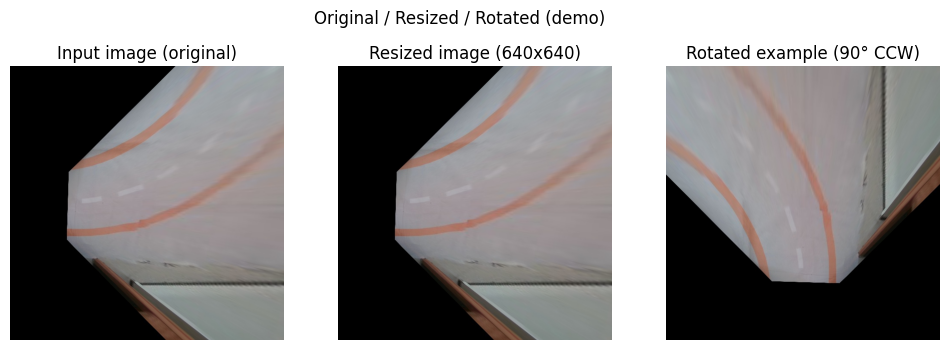

True

In [93]:
# Load image
img = get_input_image(PARAMS)
img_resized = resize_img(img, PARAMS)
H,W = img_resized.shape[:2]
ROI_MASK, ROI_POLY_PTS = build_roi_mask_from_norm(PARAMS['roi_poly_norm'], W, H)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.title('Input image (original)'); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)); plt.title(f'Resized image ({W}x{H})'); plt.axis('off')
img = cv2.rotate(img_resized, cv2.ROTATE_90_COUNTERCLOCKWISE)
plt.subplot(1,3,3); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.title('Rotated example (90° CCW)'); plt.axis('off')
plt.suptitle('Original / Resized / Rotated (demo)')
plt.show()
cv2.imwrite(os.path.join(PARAMS['output_dir'], 'image_resized.png'), img_resized[:,:,::-1])


### ROI overlay
 Shows ROI polygon overlay and extracted ROI image.

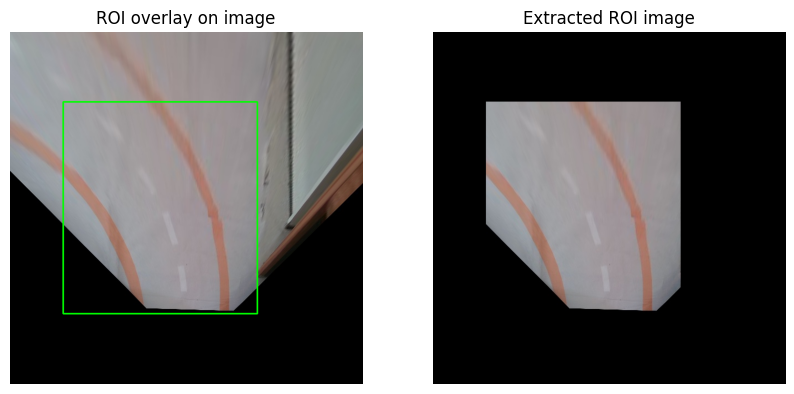

True

In [94]:
ov = img.copy()
cv2.polylines(ov, [ROI_POLY_PTS], isClosed=True, color=(0,255,0), thickness=2)
img = cv2.bitwise_and(img, img, mask=ROI_MASK)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(cv2.cvtColor(ov, cv2.COLOR_BGR2RGB)); plt.title('ROI overlay on image'); plt.axis('off')
plt.subplot(1,2,2); plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)); plt.title('Extracted ROI image'); plt.axis('off')
plt.show()
cv2.imwrite(os.path.join(PARAMS['output_dir'], 'roi_overlay.png'), ov[:,:,::-1])
cv2.imwrite(os.path.join(PARAMS['output_dir'], 'roi_extracted.png'), img[:,:,::-1])


### 4. HSV conversion — H,S,V channels & histograms

What this step does:
- Converts the image to OpenCV HSV (H range 0..179).
- Shows the H, S, V channels and their histograms. This helps choose `hsv_lower` and `hsv_upper`.

Parameters:
- `hsv_lower` and `hsv_upper`: tuples (H,S,V) in OpenCV ranges.

How parameter changes affect output:
- Narrower H range reduces false positives (e.g., road markings of other colors) but may miss faded paint.
- Raising `S` minimum removes desaturated (grey/white) portions; may remove pale lane paint.
- Raising `V` minimum removes dark shadow regions.

Diagnostics:
- H histogram: look for peaks corresponding to lane paint hue.
- Inspect S and V histograms to avoid thresholds that cut off the lane cluster.
- Example: if lane hue appears as H~10..30, set `hsv_lower[0]` slightly lower and `hsv_upper[0]` slightly higher than that cluster.


### HSV conversion — channels & histograms
 Shows H,S,V channels + histograms (OpenCV H range: 0–179)

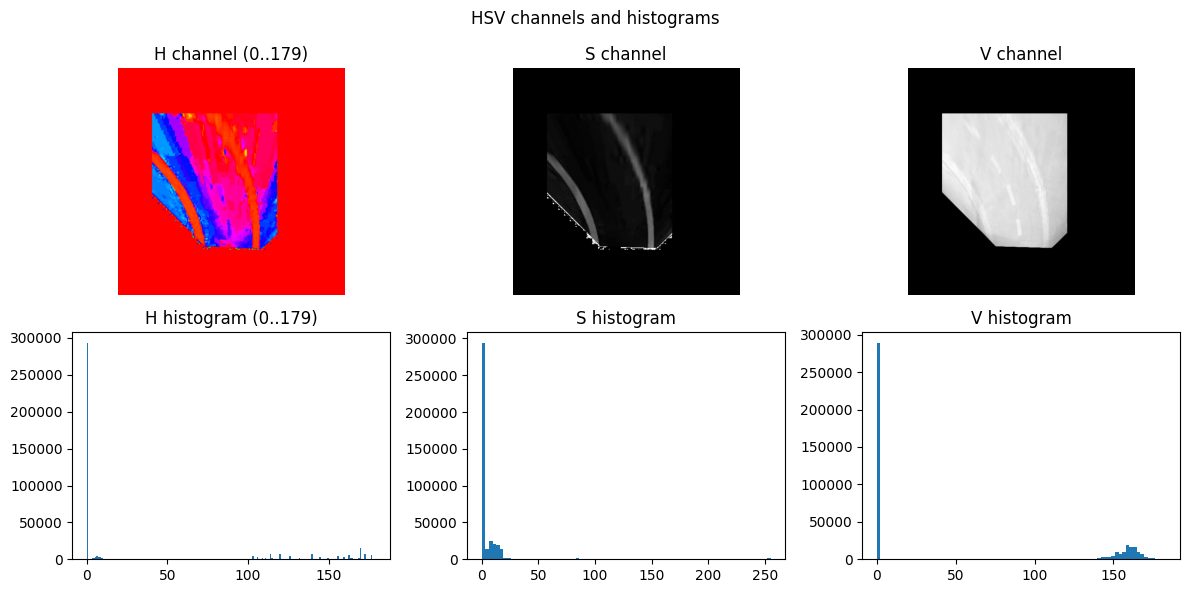

True

In [95]:
mask, hsv = hsv_lane_mask(img, PARAMS['hsv_lower'], PARAMS['hsv_upper'],
                          morph_k=PARAMS['morph_kernel'], morph_iter=PARAMS['morph_iterations'])
Hch,Sch,Vch = hsv[:,:,0], hsv[:,:,1], hsv[:,:,2]

plt.figure(figsize=(12,6))
plt.subplot(2,3,1); plt.imshow(Hch, cmap='hsv'); plt.title('H channel (0..179)'); plt.axis('off')
plt.subplot(2,3,2); plt.imshow(Sch, cmap='gray'); plt.title('S channel'); plt.axis('off')
plt.subplot(2,3,3); plt.imshow(Vch, cmap='gray'); plt.title('V channel'); plt.axis('off')
plt.subplot(2,3,4); plt.hist(Hch.ravel(), bins=180, range=(0,179)); plt.title('H histogram (0..179)')
plt.subplot(2,3,5); plt.hist(Sch.ravel(), bins=80); plt.title('S histogram')
plt.subplot(2,3,6); plt.hist(Vch.ravel(), bins=80); plt.title('V histogram')
plt.suptitle('HSV channels and histograms'); plt.tight_layout(); plt.show()
cv2.imwrite(os.path.join(PARAMS['output_dir'],'h_channel.png'), normalize_to_8u(Hch))
cv2.imwrite(os.path.join(PARAMS['output_dir'],'s_channel.png'), normalize_to_8u(Sch))
cv2.imwrite(os.path.join(PARAMS['output_dir'],'v_channel.png'), normalize_to_8u(Vch))


### 5. HSV thresholding — Show multiple parameter sets side-by-side

What this step does:
- Applies several HSV ranges (nominal, narrower-H, wider-S) and displays:
  - binary mask (0/255)
  - overlay on original
  - histogram of selected pixels' H values

Parameters:
- The candidate sets are examples — to tune, edit the sets and rerun this cell.

How changes affect output:
- `narrowH` will be more selective — fewer but more pure lane pixels.
- `widerS` will accept more desaturated pixels (may add false positives from road surface).

Diagnostics:
- Inspect overlays to check whether lane paint pixels are captured and background is rejected.
- Inspect H histogram for each mask to make sure mask picks a coherent H cluster.


### HSV thresholding — three parameter sets side-by-side
 For each: binary mask, overlay, H histogram of selected pixels

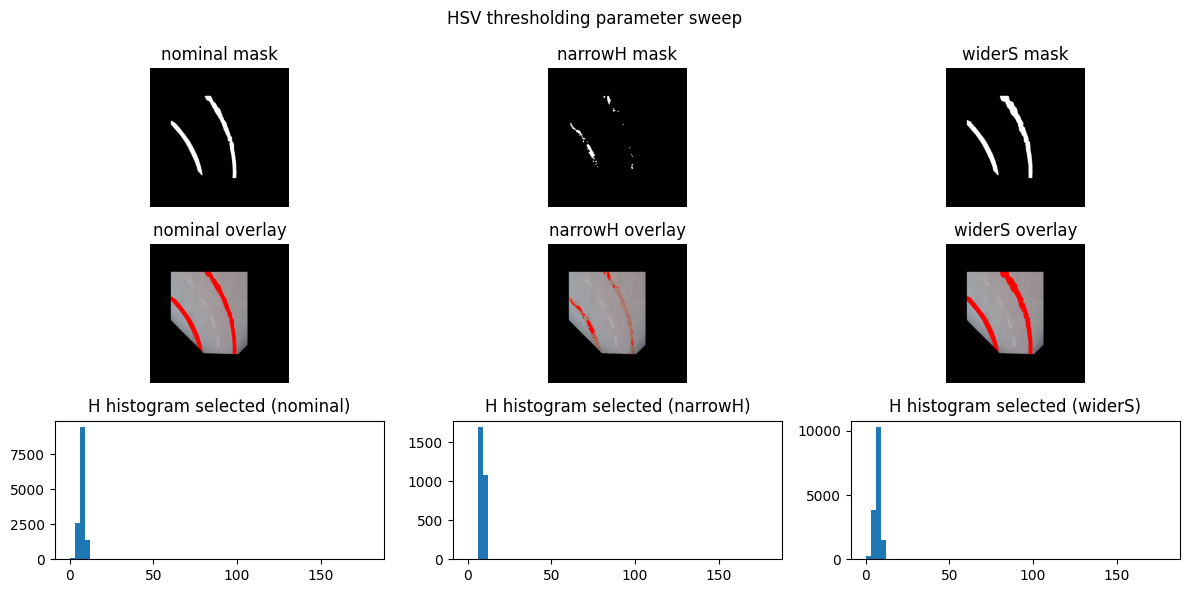

In [96]:
# %%
candidates = [
    ('nominal', PARAMS['hsv_lower'], PARAMS['hsv_upper']),
    ('narrowH', (max(0,PARAMS['hsv_lower'][0]+6), PARAMS['hsv_lower'][1], PARAMS['hsv_lower'][2]), (min(179,PARAMS['hsv_upper'][0]-4), PARAMS['hsv_upper'][1], PARAMS['hsv_upper'][2])),
    ('widerS', (PARAMS['hsv_lower'][0], max(0,PARAMS['hsv_lower'][1]-20), PARAMS['hsv_lower'][2]), (PARAMS['hsv_upper'][0], 255, PARAMS['hsv_upper'][2]))
]

import matplotlib.pyplot as plt
n = len(candidates)
plt.figure(figsize=(4*n,6))
for i,(name,low,high) in enumerate(candidates):
    msk, hsv_local = hsv_lane_mask(img, low, high,
                                   morph_k=PARAMS['morph_kernel'], morph_iter=PARAMS['morph_iterations'])
    overlay = img.copy(); overlay[msk>0] = [0,0,255]
    plt.subplot(3,n,i+1); plt.imshow(msk, cmap='gray'); plt.title(f'{name} mask'); plt.axis('off')
    plt.subplot(3,n,n+i+1); plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)); plt.title(f'{name} overlay'); plt.axis('off')
    plt.subplot(3,n,2*n+i+1); plt.hist(hsv_local[:,:,0][msk>0].ravel(), bins=60, range=(0,179)); plt.title(f'H histogram selected ({name})')
plt.suptitle('HSV thresholding parameter sweep'); plt.tight_layout(); plt.show()


### 6. Morphological cleaning: opening / closing / erosion / dilation comparisons

What this step does:
- Demonstrates how different kernels and iteration counts change the mask.
- Helps remove speckle and fill short gaps in mask.

Parameters:
- `morph_kernel` (odd integer): kernel size for structuring element.
- `morph_iterations`: number of morphology iterations.

How changes affect output:
- Larger `morph_kernel` removes smaller noisy blobs but may erode thin true positives.
- Increasing `morph_iterations` amplifies the effect.
- Typical workflow: small opening (kernel=3) to remove speckle, then closing (kernel=5) to fill gaps.

Diagnostics:
- Visual comparison of original mask, eroded, dilated, opened, closed for two kernel choices.
- If true lane lines appear broken after opening, reduce kernel or iterations; if mask contains many small speckles, increase opening kernel.


### Morphological cleaning: original, eroded, dilated, opened, closed — two kernel sizes
 Compare how kernel size and iterations change results.


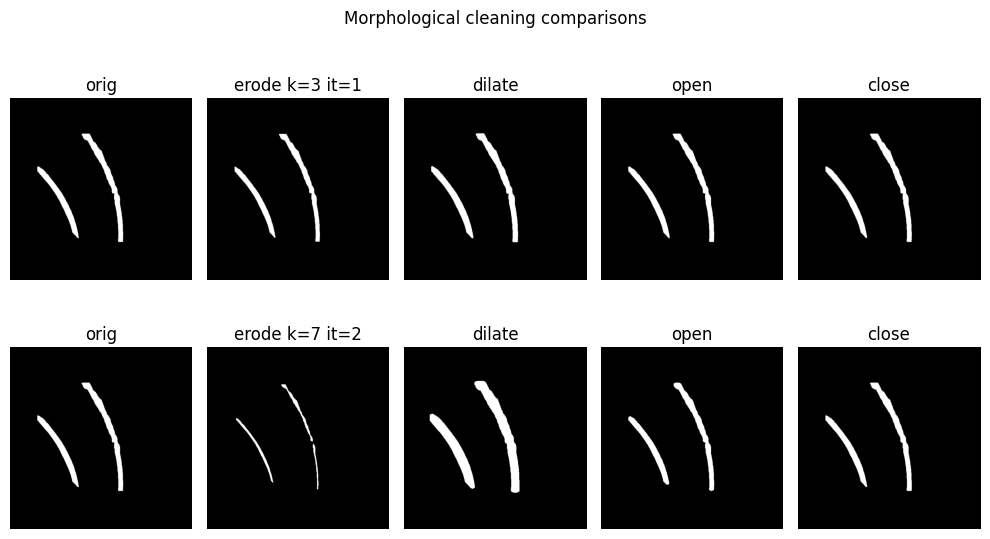

In [97]:
kernels = [(3,1),(7,2)]
plt.figure(figsize=(10,6))
for i,(k,it) in enumerate(kernels):
    k_el = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k,k))
    opened = cv2.morphologyEx(mask, cv2.MORPH_OPEN, k_el, iterations=it)
    closed = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k_el, iterations=it)
    eroded = cv2.erode(mask, k_el, iterations=it)
    dilated = cv2.dilate(mask, k_el, iterations=it)
    plt.subplot(len(kernels),5,i*5+1); plt.imshow(mask, cmap='gray'); plt.title('orig'); plt.axis('off')
    plt.subplot(len(kernels),5,i*5+2); plt.imshow(eroded, cmap='gray'); plt.title(f'erode k={k} it={it}'); plt.axis('off')
    plt.subplot(len(kernels),5,i*5+3); plt.imshow(dilated, cmap='gray'); plt.title('dilate'); plt.axis('off')
    plt.subplot(len(kernels),5,i*5+4); plt.imshow(opened, cmap='gray'); plt.title('open'); plt.axis('off')
    plt.subplot(len(kernels),5,i*5+5); plt.imshow(closed, cmap='gray'); plt.title('close'); plt.axis('off')
plt.suptitle('Morphological cleaning comparisons'); plt.tight_layout(); plt.show()



### 6. Sobel edge analysis — Gx, Gy (abs), gradient magnitude, thresholds

What this step does:
- Computes Sobel X (we focus on X for vertical/lane edges), normalizes to 8-bit and produces candidate thresholds: fixed, percentile, Otsu.

Parameters:
- `sobel_ksize` (1,3,5,7): filter kernel for derivative.
- `sobel_percentile`: use this percentile on normalized Sobel to generate a binary edge mask.
- `sobel_fixed_thresh`: alternative fixed threshold.

How changes affect output:
- Larger `sobel_ksize` smooths noise (reduce spurious edges) but blurs sharp edges.
- Higher `sobel_percentile` → fewer strong edges kept.

Diagnostics:
- View raw Sobel abs, normalized 8-bit image, histogram & thresholded masks (fixed / percentile / Otsu).
- If lane edges are missing, lower percentile or ksize; if too noisy, raise percentile or increase ksize.


### Sobel edge analysis: Gx magnitude, norm, histogram, and threshold candidates


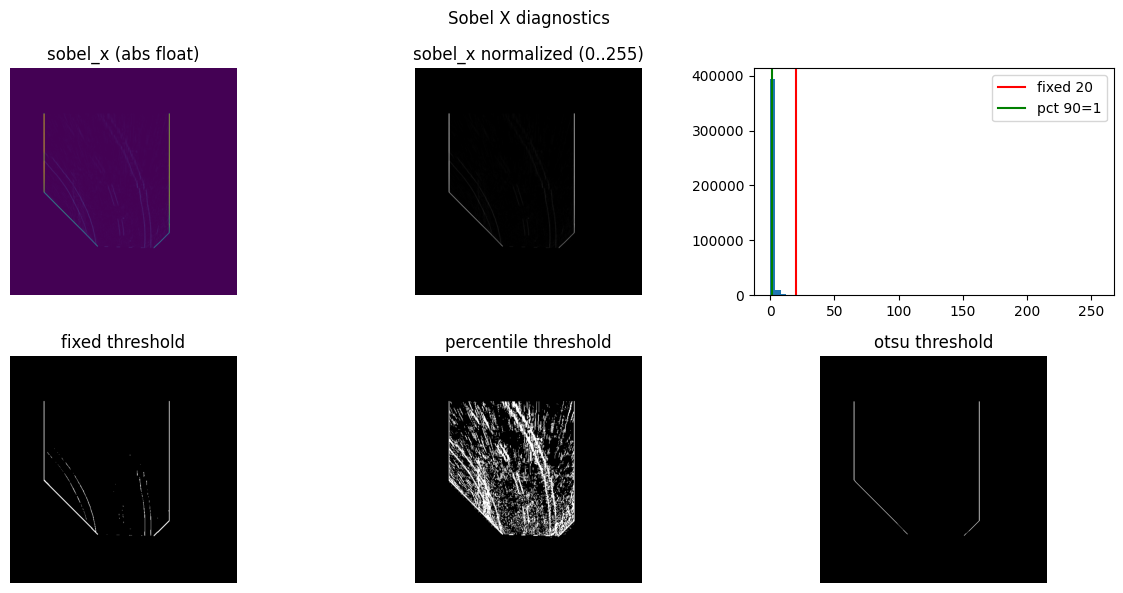

True

In [98]:
sx = sobel_x_magnitude(img, ksize=PARAMS['sobel_ksize'])
sx8 = normalize_to_8u(sx)
fixed_T = PARAMS['sobel_fixed_thresh']
percentile_T = int(np.percentile(sx8.flatten(), PARAMS['sobel_percentile']))
otsu_T, otsu_bin = cv2.threshold(sx8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

sobel_mask_fixed = (sx8 > fixed_T).astype(np.uint8) * 255
sobel_mask_pct = (sx8 > percentile_T).astype(np.uint8) * 255
sobel_mask_otsu = otsu_bin

plt.figure(figsize=(12,6))
plt.subplot(2,3,1); plt.imshow(sx, cmap='viridis'); plt.title('sobel_x (abs float)'); plt.axis('off')
plt.subplot(2,3,2); plt.imshow(sx8, cmap='gray'); plt.title('sobel_x normalized (0..255)'); plt.axis('off')
plt.subplot(2,3,3); plt.hist(sx8.ravel(), bins=64); plt.axvline(fixed_T, color='r', label=f'fixed {fixed_T}'); plt.axvline(percentile_T, color='g', label=f'pct {PARAMS["sobel_percentile"]}={percentile_T}'); plt.legend()
plt.subplot(2,3,4); plt.imshow(sobel_mask_fixed, cmap='gray'); plt.title('fixed threshold'); plt.axis('off')
plt.subplot(2,3,5); plt.imshow(sobel_mask_pct, cmap='gray'); plt.title('percentile threshold'); plt.axis('off')
plt.subplot(2,3,6); plt.imshow(sobel_mask_otsu, cmap='gray'); plt.title('otsu threshold'); plt.axis('off')
plt.suptitle('Sobel X diagnostics'); plt.tight_layout(); plt.show()

cv2.imwrite(os.path.join(PARAMS['output_dir'], 'sobel_x.png'), sx8)
cv2.imwrite(os.path.join(PARAMS['output_dir'], 'sobel_mask_pct.png'), sobel_mask_pct)


### 7. Fused mask: color evidence (S) + sobel evidence; threshold sweep help

What this step does:
- Builds a soft `color_score` from the S channel masked by HSV mask and a normalized `sobel_score`.
- Fuses them with weights `alpha_color`, `beta_sobel` and thresholds `fusion_threshold`.
- Provides histogram and CDF for choosing a threshold.

Parameters:
- `alpha_color` / `beta_sobel`: weights for fusion (sum recommended ≈ 1)
- `fusion_threshold`: threshold on fused score to create final binary

How changes affect output:
- Increase `alpha_color` to favor color (good when lane color is reliable).
- Increase `beta_sobel` to favor edges (useful when color varies).
- Increase `fusion_threshold` to be more conservative (fewer false positives), decrease to include thin / faded lines.

Diagnostics:
- Plot: color_score, sobel_score, fused score, histogram and CDF with candidate thresholds (top 1/2/5/10% and Otsu).
- Choose threshold visually where fused-score CDF jumps from background to lane cluster.


### Combined binary used for detection: color-only, edges-only, fused combined
Show the color mask, the edge map and the combined result (overlay). Also show CDF & percentile candidates.


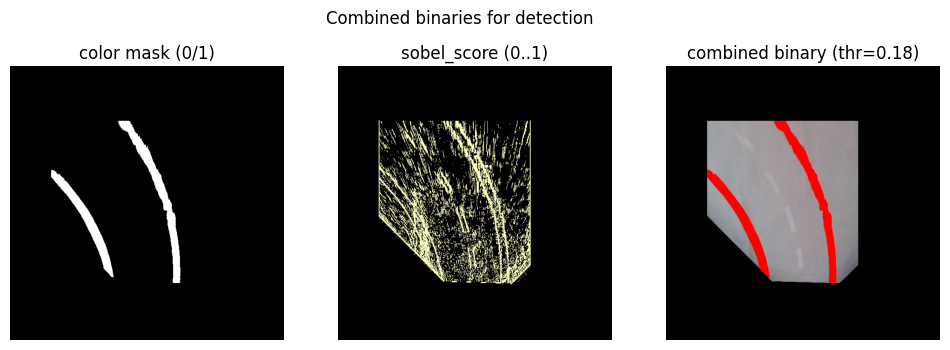

True

In [99]:
S = hsv[:,:,1].astype(np.float32)/255.0
color_binary = (mask>0).astype(np.uint8)
color_score = color_binary.astype(np.float32) * S
sobel_score = sobel_mask_pct.astype(np.float32)/255.0
alpha = PARAMS['alpha_color']; beta = PARAMS['beta_sobel']
fused_score = alpha*color_score + beta*sobel_score
thr = PARAMS['fusion_threshold']
final_binary = (fused_score >= thr).astype(np.uint8)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
#plt.subplot(1,3,1); plt.imshow(color_binary, cmap='gray'); plt.title('color mask (0/1)'); plt.axis('off')
plt.subplot(1,3,1); plt.imshow(final_binary, cmap='gray'); plt.title('color mask (0/1)'); plt.axis('off')

plt.subplot(1,3,2); plt.imshow(sobel_score, cmap='magma'); plt.title('sobel_score (0..1)'); plt.axis('off')
plt.subplot(1,3,3); ov = img.copy(); ov[final_binary>0] = [0,0,255]; plt.imshow(cv2.cvtColor(ov, cv2.COLOR_BGR2RGB)); plt.title(f'combined binary (thr={thr})'); plt.axis('off')
plt.suptitle('Combined binaries for detection'); plt.show()

# Save
cv2.imwrite(os.path.join(PARAMS['output_dir'], 'mask_color.png'), (color_binary*255).astype('uint8'))
cv2.imwrite(os.path.join(PARAMS['output_dir'], 'combined_binary.png'), (final_binary*255).astype('uint8'))


In [100]:
final_binary = (fused_score >= thr).astype(np.uint8)

### 8. Sliding-window detection — grids, centroid correction, base histogram, polynomial fit & overlays

What this step does:
- Uses the final binary to compute `nonzero_xy`.
- Finds base anchors from bottom-region histogram (left & right).
- Runs sliding-window search across `win_count` vertical windows to compute centroids.
- Fits polynomials x(y) for left and right sides and constructs a centerline.

Parameters:
- `win_count`: vertical number of windows.
- `win_half_width`: lateral half-width of each window’s search area.
- `win_min_pixels`: minimum pixels in a window to accept a centroid.
- `win_start_y`, `win_end_y`: start and end Y coordinates of search range (bottom -> top).

How changes affect output:
- Increasing `win_half_width` helps find centroids under larger lateral drift but risks associating to other lane.
- Increasing `win_min_pixels` rejects spurious tiny clusters.
- `win_count` controls vertical resolution of detections.

Diagnostics & plots required:
- Grid of boxes only (windows-only) across the image (no centroid recentring).
- After centroid correction: show centroid-centered boxes.
- Histogram used for finding base anchors (bottom region column sum).
- Visualize nonzero pixels used for fitting (color-coded L/R).
- Overlay polynomial fits and centerline(s) on original image.
- Show "windows-only" debug and "centroid-corrected + fit" images with legends.


### Sliding-window detection: windows-only, centroid-corrected, base histogram, nonzero points, polynomial fits, overlay.


In [101]:
final_binary_01 = (final_binary > 0).astype(np.uint8)

# (optional) convert to 0/255 if you still need that elsewhere:
final_binary_255 = (final_binary_01 * 255).astype(np.uint8)

# debug example call:
baseX, presence = compute_base_anchors_from_binary(
    final_binary_01,
    hist_peak_min_value=PARAMS['hist_peak_min_value'],
    min_lane_distance=PARAMS['min_lane_distance'],
    win_half_width=PARAMS['win_half_width'],
    bottom_frac=1.0/3.0,      # use bottom third as requested
    morph_kernel=5,           # optional: denoise
    morph_iters=1,
    debug=True,               # print internal values so you can see why a lane was rejected
    adapt_threshold_if_too_high=True
)

l_x, r_x = baseX
useL, useR = presence

nonzero_xy = to_nonzero_xy(final_binary_255)  # keep this if you still need 0..255 input

print("Left base x:", l_x)
print("Right base x:", r_x)
print("Use left lane:", useL)
print("Use right lane:", useR)


---- compute_base_anchors_from_binary debug ----
image w,h: 640,640   bottom_frac: 0.3333333333333333   rb_h: 213
kernel_size: 71
bestL: 206  maxL (smoothed count): 16.68
bestR: 362  maxR (smoothed count): 19.15
overall_max: 19.15  thresh: 5.00
left neigh (idx 203..209): [16.23943662 16.47887324 16.61971831 16.67605634 16.67605634 16.67605634
 16.67605634]
right neigh (idx 359..365): [16.77464789 17.85915493 18.74647887 19.15492958 19.15492958 19.15492958
 19.15492958]
useLeft: True  useRight: True
-----------------------------------------------
Left base x: 206
Right base x: 362
Use left lane: True
Use right lane: True


## Sliding Window Visualization

**Left Panel – Before:**

* Dashed boxes and triangles (`v`) show the initial window positions and centroids.
* **Cyan** = left window, **Magenta** = right window.

**Right Panel – After:**

* Solid boxes and circles (`o`) show the final, re-centered windows and centroids after sliding.
* Same color coding.


498


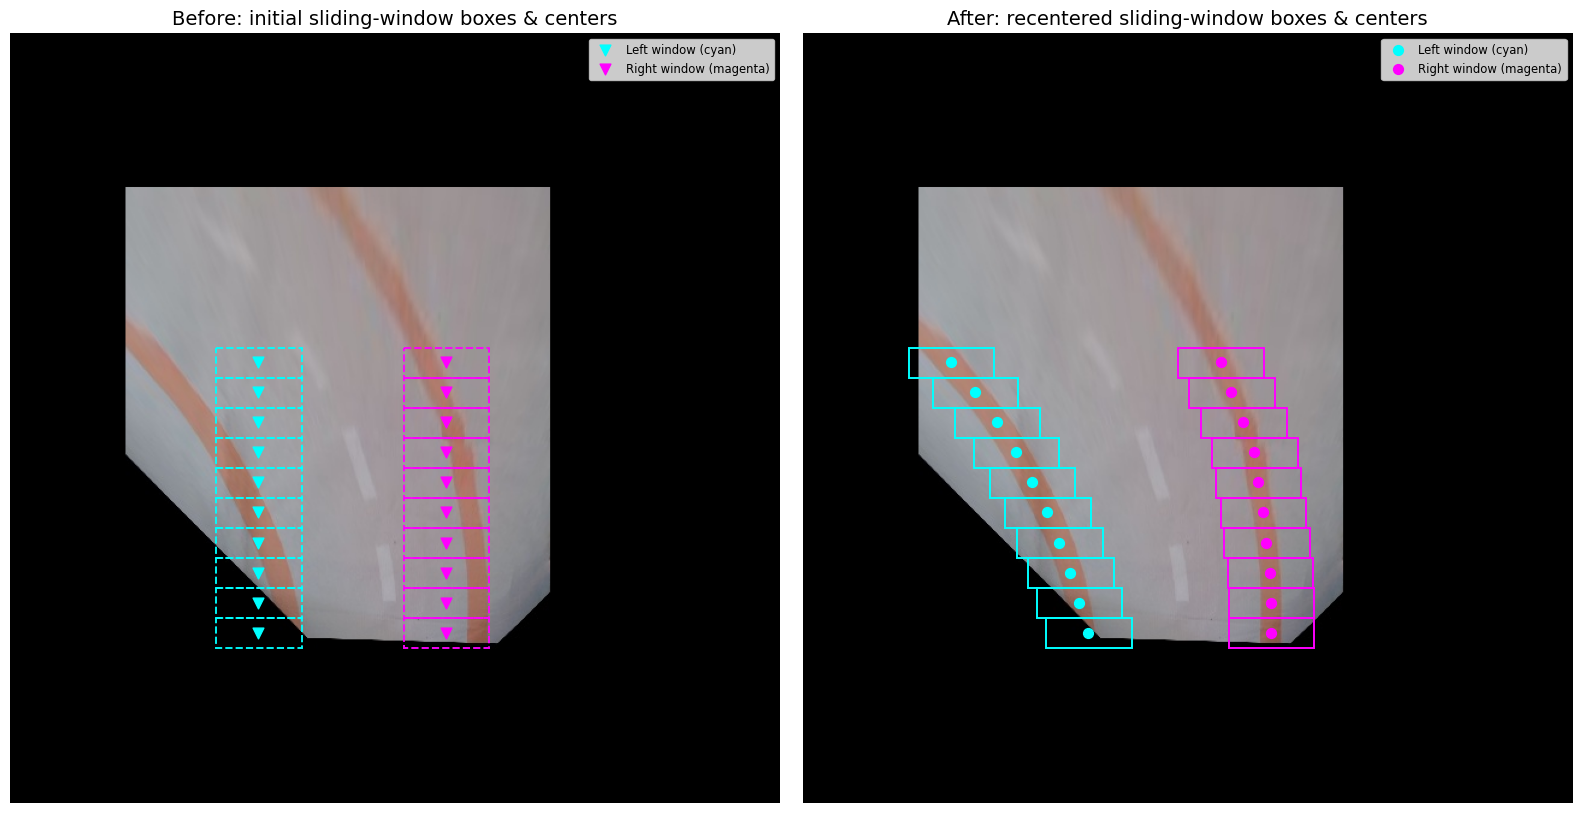

In [102]:

from matplotlib.patches import Rectangle

h, w = mask.shape[:2]
win_count = PARAMS['win_count']
win_start = PARAMS['win_start_y']; win_end = PARAMS['win_end_y']
if win_start <= win_end:
    win_start = h - 1
    win_end = int(h / 4)
vertical_span = max(1, win_start - win_end)
win_h = max(1, vertical_span // max(1, win_count))

# compute y ranges
win_y_low, win_y_high = [], []
for i in range(win_count):
    low = int(max(0, win_start - (i + 1) * win_h + 1))
    high = int(min(h - 1, win_start - i * win_h))
    win_y_low.append(low)
    win_y_high.append(high)
# bottommost window is level 0
ylow_bottom = win_y_low[0]
yhigh_bottom = win_y_high[0]

# centroid y of the bottom window
cy_bottom = (ylow_bottom + yhigh_bottom) // 2

print(cy_bottom)
# initial boxes/centers
init_centers, init_boxes = {0: [], 1: []}, {0: [], 1: []}
winHalf = max(PARAMS['min_win_half'], PARAMS['win_half_width'])
for level in range(win_count):
    ylow, yhigh = win_y_low[level], win_y_high[level]
    cy = (ylow + yhigh) // 2
    # left
    cxL = int(baseX[0])
    xlowL = max(0, cxL - winHalf)
    width = min(w - 1, cxL + winHalf) - xlowL + 1
    init_centers[0].append((cxL, cy))
    init_boxes[0].append((xlowL, ylow, width, yhigh - ylow + 1))
    # right
    cxR = int(baseX[1])
    xlowR = max(0, cxR - winHalf)
    widthR = min(w - 1, cxR + winHalf) - xlowR + 1
    init_centers[1].append((cxR, cy))
    init_boxes[1].append((xlowR, ylow, widthR, yhigh - ylow + 1))

# final sliding windows
window_centroids, lane_idxs = sliding_windows_from_mask(mask, nonzero_xy, baseX, PARAMS)
final_boxes, final_centers = {0: [], 1: []}, {0: [], 1: []}
for side in [0,1]:
    for lvl, centroid in enumerate(window_centroids[side]):
        cx, cy = centroid
        ylow, yhigh = win_y_low[lvl], win_y_high[lvl]
        xlow = max(0, int(cx) - winHalf)
        width = min(w - 1, int(cx) + winHalf) - xlow + 1
        final_boxes[side].append((xlow, ylow, width, yhigh - ylow + 1))
        final_centers[side].append((int(cx), int(cy)))

# --- Plot side-by-side ---
colors = {
    0: {'box':'cyan','centroid':'cyan', 'label':'Left window (cyan)'},
    1: {'box':'magenta','centroid':'magenta', 'label':'Right window (magenta)'}
}

fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# LEFT: initial
ax = axs[0]
ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax.set_title('Before: initial sliding-window boxes & centers', fontsize=14)
ax.axis('off')

for side in [0,1]:
    for (x, y, width, height) in init_boxes[side]:
        rect = Rectangle((x, y), width, height, linewidth=1.4,
                         edgecolor=colors[side]['box'], facecolor='none',
                         linestyle='--', alpha=0.95)
        ax.add_patch(rect)
    xs = [c[0] for c in init_centers[side]]
    ys = [c[1] for c in init_centers[side]]
    ax.scatter(xs, ys, marker='v', s=60, c=colors[side]['centroid'],
               label=colors[side]['label'], zorder=5)

ax.legend(loc='upper right', fontsize='small')

# RIGHT: final
ax = axs[1]
ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax.set_title('After: recentered sliding-window boxes & centers', fontsize=14)
ax.axis('off')

for side in [0,1]:
    for (x, y, width, height) in final_boxes[side]:
        rect = Rectangle((x, y), width, height, linewidth=1.4,
                         edgecolor=colors[side]['box'], facecolor='none',
                         linestyle='-', alpha=1.0)
        ax.add_patch(rect)
    xs = [c[0] for c in final_centers[side]]
    ys = [c[1] for c in final_centers[side]]
    ax.scatter(xs, ys, marker='o', s=50, c=colors[side]['centroid'],
               label=colors[side]['label'], zorder=6)

ax.legend(loc='upper right', fontsize='small')

plt.tight_layout()
plt.show()


Left poly coeffs: [-1.33939394e-03  1.53061212e+00 -1.94297055e+02]
Right poly coeffs: [-1.01818182e-03  9.67563636e-01  1.59066473e+02]


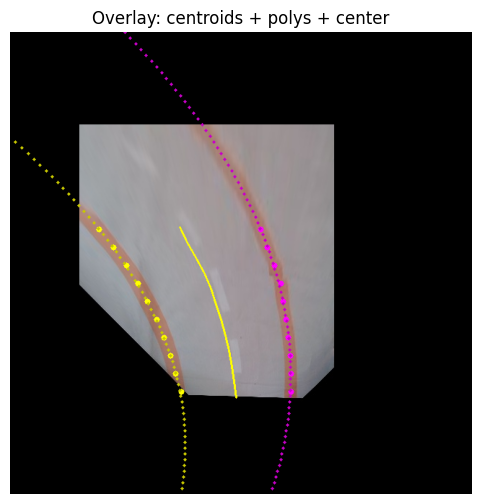

True

In [103]:
# Fit polynomials
left_coeffs = fit_poly_from_points(window_centroids[0], deg=PARAMS['poly_degree'])
right_coeffs = fit_poly_from_points(window_centroids[1], deg=PARAMS['poly_degree'])
print('Left poly coeffs:', left_coeffs); print('Right poly coeffs:', right_coeffs)

# overlay polylines
overlay = img.copy()
for (x,y) in window_centroids[0]: cv2.circle(overlay, (int(x),int(y)), 4, (0,255,255), -1)
for (x,y) in window_centroids[1]: cv2.circle(overlay, (int(x),int(y)), 4, (255,0,255), -1)

ys = np.arange(0,H)
if left_coeffs is not None:
    xsL = np.poly1d(left_coeffs)(ys).astype(int)
    for y in range(0,H,8):
        x = int(xsL[y]) if 0<=xsL[y]<W else None
        if x is not None and 0<=x<W: cv2.circle(overlay,(x,y),2,(0,200,200),-1)
if right_coeffs is not None:
    xsR = np.poly1d(right_coeffs)(ys).astype(int)
    for y in range(0,H,8):
        x = int(xsR[y]) if 0<=xsR[y]<W else None
        if x is not None and 0<=x<W: cv2.circle(overlay,(x,y),2,(200,0,200),-1)

center_poly = compute_center_polyline(window_centroids, PARAMS)
for i in range(len(center_poly)-1):
    x0,y0 = int(center_poly[i][0]), int(center_poly[i][1]); x1,y1 = int(center_poly[i+1][0]), int(center_poly[i+1][1])
    cv2.line(overlay, (x0,y0), (x1,y1), (0,255,255), 2)

plt.figure(figsize=(6,6)); plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB)); plt.title('Overlay: centroids + polys + center'); plt.axis('off'); plt.show()
cv2.imwrite(os.path.join(PARAMS['output_dir'], 'final_overlay.png'), overlay[:,:,::-1])


### 9. Lane-Keeping Lateral Deviation Calculation (Pixels)

To compute the desired steering angle for lane keeping, we use simple **vehicle dynamics geometry** and a **lookahead point** along the lane centerline. The lookahead point (tunable) allows us to anticipate the lane curvature and adjust steering proactively.

The **total lateral deviation** at the lookahead point is calculated as the sum of three contributions:

1. **Current vehicle offset (`dy0`)**: the horizontal distance from the vehicle’s current center to the bottom/front centerline point.
2. **Curve-induced shift (`curve_px`)**: the horizontal displacement between the front centerline point and the lookahead point due to lane curvature.
3. **Steering-induced shift (`s_phi_px`)**: the lateral shift caused by the vehicle’s current steering angle (assumed 5° here).

The resulting **total deviation (`Delta_total_px`)** represents the control error for lane keeping. This deviation can then be used as the **target error** to compute the **desired steering angle** that keeps the vehicle centered in the lane.

All calculations are performed **purely in pixel coordinates**, with the image convention `(0,0)` at the top-left, `x` increasing to the right, and `y` increasing downward. The overlay visualization shows the centerline, front and lookahead points, and all deviations with arrows for clarity.
### Vehicle Dynamics Reference

Below are reference illustrations for the lane-keeping geometry[:

<table>
<tr>
<td><img src="./data/1.png" width="500"></td>
<td><img src="./data/2.png" width="500"></td>
</tr>
</table>



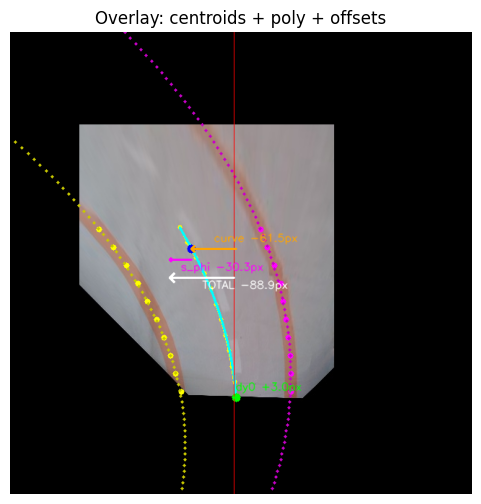

Saved overlay to: outputs/final_overlay_with_offsets.png
===== LATERAL DEVIATION CALCULATION =====

Quantity                          Pixels         Meters
-------------------------------------------------------
Curvature radius (R)              641.44          1.210
Front offset (dy0)                  3.00          0.006
Curve shift                       -61.54         -0.116
Steering shift (s_phi)            -30.33         -0.057
TOTAL Deviation                   -88.87         -0.168



In [104]:
import numpy as np
import math
import cv2
import os
import matplotlib.pyplot as plt

# ---------------- USER PARAMETERS ----------------
X0 = 310.0           # vehicle reference center x in pixels
LOOK_Y_PX = 300.0    # lookahead y pixel
L_px = 250.0         # lookahead distance in pixels
WHEELBASE_PX = 0.17 / 0.33 * 175.0  # approximate wheelbase in pixels
PHI_DEG = 5.0

# Overlay image (dummy example; replace with actual BEV overlay)
if 'overlay' not in globals():
    overlay = np.zeros((600, 640, 3), dtype=np.uint8)

# Example centerline points (replace with actual centroids from pipeline)
if 'center_poly' not in globals():
    center_poly = [[320, 500],[325, 400],[330, 300]]

# ---------------- POLYNOMIAL FIT ----------------
centers_arr = np.asarray(center_poly, dtype=float)
ys = centers_arr[:, 1]
xs = centers_arr[:, 0]

deg_fit = 2 if ys.size >= 3 else max(1, ys.size - 1)
coeffs_px = np.polyfit(ys, xs, deg_fit)
p_px = np.poly1d(coeffs_px)

# ---------------- COMPUTE LATERAL POINTS ----------------
y_look_px = float(LOOK_Y_PX)
x_look_px = float(p_px(y_look_px))

idx_front = np.argmax(ys)
x_front_px = xs[idx_front]
y_front_px = ys[idx_front]

dy0_px = x_front_px - X0
curve_px = x_look_px - x_front_px

phi_rad = math.radians(PHI_DEG)
s_phi_px = - (L_px**2 * math.tan(phi_rad) / (2 * WHEELBASE_PX)) if abs(phi_rad) > 1e-12 else 0.0

Delta_total_px = dy0_px + curve_px + s_phi_px

# ---------------- CURVATURE CALCULATION ----------------
xprime_px = p_px.deriv(1)(y_look_px)
x2prime_px = p_px.deriv(2)(y_look_px)
kappa_px = abs(x2prime_px) / (1 + xprime_px**2)**1.5
R_px = 1.0 / kappa_px if kappa_px > 1e-12 else float('inf')

# ---------------- PIXEL TO METER CONVERSION ----------------
XM_PER_PX = 0.33 / 175.0
R_m = R_px * XM_PER_PX
dy0_m = dy0_px * XM_PER_PX
curve_m = curve_px * XM_PER_PX
s_phi_m = s_phi_px * XM_PER_PX
Delta_total_m = Delta_total_px * XM_PER_PX

# ---------------- OVERLAY VISUALIZATION ----------------
vis = overlay.copy()

# Draw centerline points
for x, y in zip(xs, ys):
    cv2.circle(vis, (int(round(x)), int(round(y))), 3, (0,255,255), -1)  # yellow

# Draw fitted curve
y_plot = np.linspace(min(ys), max(ys), 400)
x_plot = p_px(y_plot)
for i in range(len(x_plot)-1):
    cv2.line(vis, (int(round(x_plot[i])), int(round(y_plot[i]))),
             (int(round(x_plot[i+1])), int(round(y_plot[i+1]))), (255,255,0), 2)  # cyan

# Draw front and lookahead points
cv2.circle(vis, (int(round(x_front_px)), int(round(y_front_px))), 6, (0,255,0), -1)  # green
cv2.circle(vis, (int(round(x_look_px)), int(round(y_look_px))), 6, (255,0,0), -1)    # blue

# Vehicle reference line
cv2.line(vis, (int(round(X0)), 0), (int(round(X0)), vis.shape[0]-1), (0,0,255), 1)  # red

# Draw arrows for deviations
shifted_look_px = x_look_px + s_phi_px

cv2.arrowedLine(vis, (int(round(X0)), int(round(y_front_px))),
                (int(round(x_front_px)), int(round(y_front_px))), (0,255,0), 2)
cv2.arrowedLine(vis, (int(round(x_front_px)), int(round(y_look_px))),
                (int(round(x_look_px)), int(round(y_look_px))), (0,165,255), 2)
cv2.arrowedLine(vis, (int(round(x_look_px)), int(round(y_look_px+15))),
                (int(round(shifted_look_px)), int(round(y_look_px+15))), (255,0,255), 2)
final_px = X0 + Delta_total_px
cv2.arrowedLine(vis, (int(round(X0)), int(round(y_look_px+40))),
                (int(round(final_px)), int(round(y_look_px+40))), (255,255,255), 2)

# Optional text labels
cv2.putText(vis, f"dy0 {dy0_px:+.1f}px",
            (int(round((X0+x_front_px)/2)), int(round(y_front_px)-10)),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1, cv2.LINE_AA)
cv2.putText(vis, f"curve {curve_px:+.1f}px",
            (int(round((x_front_px+x_look_px)/2)), int(round(y_look_px)-10)),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,165,255), 1, cv2.LINE_AA)
cv2.putText(vis, f"s_phi {s_phi_px:+.1f}px",
            (int(round((x_look_px+shifted_look_px)/2)), int(round(y_look_px+30))),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,255), 1, cv2.LINE_AA)
cv2.putText(vis, f"TOTAL {Delta_total_px:+.1f}px",
            (int(round((X0+final_px)/2)), int(round(y_look_px+55))),
            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,255,255), 1, cv2.LINE_AA)

# ---------------- SHOW OVERLAY ----------------
plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
plt.title('Overlay: centroids + poly + offsets')
plt.axis('off')
plt.show()

# ---------------- SAVE OVERLAY ----------------
out_dir = 'outputs'
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, 'final_overlay_with_offsets.png')
cv2.imwrite(out_path, vis[:, :, ::-1])  # BGR -> RGB
print("Saved overlay to:", out_path)

# ---------------- PRINT LATERAL DEVIATION ----------------
print("===== LATERAL DEVIATION CALCULATION =====\n")
print(f"{'Quantity':<25}{'Pixels':>15}{'Meters':>15}")
print("-"*55)
print(f"{'Curvature radius (R)':<25}{R_px:>15.2f}{R_m:>15.3f}")
print(f"{'Front offset (dy0)':<25}{dy0_px:>15.2f}{dy0_m:>15.3f}")
print(f"{'Curve shift':<25}{curve_px:>15.2f}{curve_m:>15.3f}")
print(f"{'Steering shift (s_phi)':<25}{s_phi_px:>15.2f}{s_phi_m:>15.3f}")
print(f"{'TOTAL Deviation':<25}{Delta_total_px:>15.2f}{Delta_total_m:>15.3f}")
print("===============================================\n")


### 10. Lane-Centering Control (Cascade + Feedforward)

We use a **cascade + feedforward lane-centering controller** that considers:

* Current lateral deviation and lookahead deviation
* Lane curvature (`R`)
* Current speed (`v_cur`) and steering angle (`delta_cur`)

The **total deviation** combines: current offset, curve shift, and steering-induced shift. The **desired steering angle** uses:

* **Feedback** from deviation and yaw angle errors
* **Feedforward** from lane curvature (`v/R`)

**Tunable parameters**: controller gains (`K1, K2, K3`), lookahead distance, and scaling factors for speed and steering (`k_v`, `k_delta`).

Below are reference **block diagram** and **formulas**:

<table>
<tr>
<td><img src="./data/3.png" width="500"></td>
<td><img src="./data/4.png" width="500"></td>
</tr>
</table>

At the end of this computation, we obtain the **desired vehicle control parameters** (speed, steering angle, steering rate) ready to **publish to the vehicle actuators** for lane keeping.

In [105]:
import math

# ---------------- PARAMETERS (single place) ----------------
# Vehicle / state
l_veh = 0.17            # wheelbase [m]
psi_cur = 0.0           # current yaw angle [rad]
psi_dot_cur = 0.0       # current yaw rate [rad/s]

# Controller gains (tunable)
K1 = 0.8   # lateral deviation -> yaw angle
K2 = 0.5   # yaw angle -> yaw rate (controller)
K3 = 1.0   # yaw rate -> steering rate (controller)

# Feedforward / tuning
k_v = 0.5        # speed factor (m/s per sqrt(m) of radius)
k_delta = 1.2    # steering scaling factor

# Driver / actuation params
driver_code = 99
steering_angle_velocity = 1.0  # nominal steering angular velocity [rad/s]

# Desired lateral deviation (target centerline)
dy_des = 0.0
dy_cur = Delta_total_m  # from lane deviation calculation above (m)

# Safety / fallbacks for radius
# R_m should be computed previously; protect against non-positive or extremely small values
R_m_safe = R_m if (R_m is not None and math.isfinite(R_m) and R_m > 0.001) else float('inf')

# ---------------- ADAPTIVE SPEED (based on curvature) ----------------
# Reduce speed for sharper curves (smaller R); fallback default speed 5.0 m/s
if R_m_safe == float('inf'):
    v_cur = 5.0
else:
    v_cur = k_v * math.sqrt(R_m_safe)
    # optional clamp to reasonable bounds
    v_cur = max(0.5, min(v_cur, 8.0))  # keep speed between 0.5 and 8 m/s

# ---------------- DESIRED YAW / YAW RATE ----------------
# Desired yaw angle from lateral deviation (proportional law)
psi_des = K1 * (dy_des - dy_cur)  # rad

# Yaw rate controller (feedback)
psi_dot_des_controller = K2 * (psi_des - psi_cur)

# Pilot/feedforward yaw rate from curvature
psi_dot_des_pilot = 0.0 if R_m_safe == float('inf') else (v_cur / R_m_safe)

# Total desired yaw rate
psi_dot_des = psi_dot_des_controller + psi_dot_des_pilot

# ---------------- STEERING (controller + feedforward) ----------------
# Steering rate demanded by controller
delta_controller = K3 * (psi_dot_des - psi_dot_cur)

# Feedforward desired steering angle from yaw rate (approximate bicycle model)
# protect against division by zero in case v_cur is extremely small
if v_cur <= 1e-3:
    delta_des = 0.0
else:
    delta_des = psi_dot_des * (l_veh / v_cur)

# Combine and scale steering
delta_total = k_delta * (delta_des + delta_controller)

# Optionally convert to degrees for easier inspection
delta_total_deg = math.degrees(delta_total)

# ---------------- PRINT SUMMARY ----------------
print("===== ADAPTIVE VEHICLE CONTROL SUMMARY =====\n")
print(f"Driver code: {driver_code}")
print(f"Steering angle velocity (nominal): {steering_angle_velocity:.3f} rad/s")

print("\n-- Curvature / speed --")
if R_m_safe == float('inf'):
    print("R_m: inf (straight / undefined). Using default speed.")
else:
    print(f"R_m: {R_m_safe:.3f} m")
print(f"Adaptive speed v_cur: {v_cur:.3f} m/s")

print("\n-- Lateral / yaw references --")
print(f"Current lateral deviation dy_cur: {dy_cur:+.3f} m (target {dy_des:.3f} m)")
print(f"Desired yaw angle psi_des: {psi_des:.4f} rad")

print("\n-- Yaw rate contributions --")
print(f"Controller yaw rate (feedback): {psi_dot_des_controller:+.4f} rad/s")
print(f"Pilot yaw rate (feedforward):   {psi_dot_des_pilot:+.4f} rad/s")
print(f"Total desired yaw rate:         {psi_dot_des:+.4f} rad/s")

print("\n-- Steering outputs --")
print(f"Controller steering term: {delta_controller:+.4f} rad")
print(f"Feedforward steering term: {delta_des:+.4f} rad")
print(f"Total steering (scaled) : {delta_total:+.4f} rad  ({delta_total_deg:+.2f} deg)")
print("==============================================\n")


===== ADAPTIVE VEHICLE CONTROL SUMMARY =====

Driver code: 99
Steering angle velocity (nominal): 1.000 rad/s

-- Curvature / speed --
R_m: 1.210 m
Adaptive speed v_cur: 0.550 m/s

-- Lateral / yaw references --
Current lateral deviation dy_cur: -0.168 m (target 0.000 m)
Desired yaw angle psi_des: 0.1341 rad

-- Yaw rate contributions --
Controller yaw rate (feedback): +0.0670 rad/s
Pilot yaw rate (feedforward):   +0.4546 rad/s
Total desired yaw rate:         +0.5217 rad/s

-- Steering outputs --
Controller steering term: +0.5217 rad
Feedforward steering term: +0.1613 rad
Total steering (scaled) : +0.8195 rad  (+46.95 deg)



## II ROS implementation

The existing software stack already provides reliable **locomotion**, **localization**, **perception**, and a calibrated **Inverse Perspective Mapping (IPM)** / BEV pipeline.
Our task is to develop a **robust image-processing and control module** that consumes the stack’s BEV and perception outputs and produces safe, real-time drive commands so the robot:

* stays centered in its lane (or follows the computed centerline), and
* behaves like a lane-keeping assistance system that is resilient to bends, curves and real-world sensor noise.

Concretely, we will deliver two tightly integrated subsystems:

1. **Robust image processing (BEV)** — extract lane polylines, curvature, lateral offset, and detection confidence from the IPM/BEV images; reject spurious detections and smooth noisy estimates.
2. **Model-aware control** — an Ackermann-aware controller that fuses predicted look-ahead deviation (from the vehicle motion model) with feedback (cascade + feedforward) and a graded look-ahead box to produce smooth, rate-limited steering commands and safe fallbacks.

## Robustness & fault handling

* **Confidence checks**: only accept lane model outputs above a confidence threshold; otherwise trigger fallback.
* **Temporal filtering**: exponential smoothing on curvature and offset to remove spikes.
* **Spike and jump rejection**: detect and ignore large instantaneous jumps (clamp + hold previous safe value).
* **Rate limiting**: limit steering command rate to avoid actuator saturation and oscillations.
* **Fallbacks**:

  * both lanes → normal combined control, prefer model-based output if confidence high.
  * single-side → use geometry + motion model + graded search turn.
  * none → slow search/stop behavior and rely on KMeans baseline as a last resort.
  * spurious detections → reject using spatial and temporal consistency checks.
* **Look-ahead box**: spatially smooths corrections (mild → medium → sharp) to avoid over-reacting to noisy instantaneous detections.

## Run & integration (short)

1. Add `Lane_detection_v3` to ROS workspace `src/`.
2. Build (`catkin_make` or `colcon build`) and source workspace.
3. Tune IPM and vehicle parameters in `params/` (homography, wheelbase).
4. Launch stack: `roslaunch lane_detection_v3 lane_detection.launch` (or use `kmeans_baseline.launch` for fallback testing).
5. Visualize `/camera/bev` and `/lane/diagnostics/*` in `rviz` during tests; record bag files for repeatable tuning.

---

### Software architecture:

![Image Processing Pipeline: From BEV Input to Vehicle Actuation](./data/modified.png)

1. KMeans baseline
2. Model-based BEV lane-keeping

# KMeans baseline (package: `realsense_image_tools`)

* New ROS package: `Lane_detection_v3` (codebase currently in package `X`).
* First, a lightweight baseline using **KMeans** on the bird’s-eye / IPM image to cluster lane pixels into two blobs (left / right).
* From those two blobs we compute center points and a centerline — the robot follows the center points.

**Simple error-handling logic**

* If **only left lane** detected → command a gentle/defined right turn to recover.
* If **only right lane** detected → command a gentle/defined left turn to search for the missing lane.
* If **both lanes** detected → follow computed centerline.
* If **none / ambiguous** → fall back to safe behavior (stop or low-speed search mode).

**Quick run (developer steps — generic)**

1. Put `Lane_detection_v3` into your workspace `src/`.
2. Build: `catkin_make` / `colcon build` (depending on ROS distro).
3. Source workspace: `source devel/setup.bash` (or `install/setup.bash`).
4. Launch node/launchfile: `roslaunch lane_detection_v3 lane_detector.launch` (or `rosrun lane_detection_v3 node_name`).
   (Adjust topic names and parameters inside the package as required.)

---

# KMeans Baseline

## 1. Build & source
From  workspace root (e.g. `~/catkin_ws`):
```bash
catkin build -j 2 -DCMAKE_BUILD_TYPE=Release
source devel/setup.bash
````

## 2. Bring up hardware + vision

```bash
roslaunch ika_racer bring_up.launch
roslaunch realsense_image_tools visioncontollnodelet.launch # for this nodelet launches IPM along with k means based lane detection
```


## 5. Params (example `vision_drive_params.yaml`)

Edit `k_steer` and other gains here:

```yaml
vision_controller:
  drive_speed: 1.00
  drive_acceleration: 0.5
  steering_angle_velocity: 3.0
  k_steer: 0.008
  slight_left_steering_angle: 1.0
  slight_right_steering_angle: -1.0
  starter_speed: 1.0
  starter_duration: 0.3  # seconds
```

## 6. topics

```bash
# topics
rostopic list | grep -E "camera|bev|lane|cmd_drive"

# inspect drive commands
rostopic echo /ika_racer/locomotion/drive_command

# record for offline tuning
rosbag record /camera/bev /lane/kmeans/centers /ika_racer/locomotion/drive_command /odom -O run_kmeans.bag
```

![fianl_display](data/0014.jpg)


# Model-aware Control

**Purpose:** Launch the Ackermann-aware controller which fuses look-ahead prediction (motion model) + cascade feedback + feedforward terms and uses a graded look-ahead box for robust steering.

> **Assumptions / notes**
> - Package: `lane_detection_v3`  
> - Hardware bring-up is handled by `ika_racer` bring-up.  
> - The controller is started via `lane_follower.launch` inside `lane_detection_v3`
> - IPM / BEV nodelet runs as part of the launch and provides the bird’s-eye view input.

---

## 1) Build & source (if not already done)
From workspace root (e.g. `~/catkin_ws`):
```bash
catkin build -j 2 -DCMAKE_BUILD_TYPE=Release
source devel/setup.bash
````

## 2) Bring up hardware

```bash
roslaunch ika_racer bring_up.launch
```

## 3) Launch model-aware lane follower

```bash
# start the lane follower (this launch starts the IPM/nodelet + controller)
roslaunch lane_detection_v3 lane_follower.launch
```

*(If your launch file has a different name, e.g. `lane_follwer.lauch`, replace with the correct filename.)*

## 4) Load / edit tuning params

Tunable parameters live here in the package (edit before or load at runtime):

```
lane_detection_v3/config/lane.yaml
```

Example keys you will find / tune:

```yaml
# config/lane.yaml

# Image target size (pixels)
target_width: 640
target_height: 640

# HSV thresholds for yellow lane detection (kept - algorithm unchanged)
hsv_yellow_lower: [2, 50, 80]
hsv_yellow_upper: [25, 200, 220]

# Polynomial fitting parameters
poly_degree: 2
fit_margin: 50
min_poly_pixels: 50

# Sliding window parameters
win_count: 12
win_half_width: 35
win_min_pixels: 10
win_start_y: 520
win_end_y: 256

# Lookahead box
lookahead_xmin: 305
lookahead_xmax: 335
lookahead_ymin: 200
lookahead_ymax: 480

# Strips and lane prior
strip_min_points: 10
min_lane_distance: 180

# Steering discrete thetas
theta_r1: 0.5
theta_r2: 1.0
theta_r3: 1.5
theta_l1: -0.5
theta_l2: -1.0
theta_l3: -1.5

# Vehicle / driver parameters (fixed)
driver_code: 99
base_acceleration: 0.3
steering_angle_velocity: 1.0

# Debug
debug: true

# Speed parameters (requested)
speed_step: 0.02
min_speed: 0.35
max_speed: 0.45

# NEW parameter — use speed sensor? (true = use sensor, false = ignore and send max_speed)
speed_senser: false

# Smoothing
steering_smooth_factor: 0.4
no_lane_speed: 0.38

# ROI polygon (normalized coords)
roi_poly_norm:
  - [0.15, 0.80]
  - [0.75, 0.80]
  - [0.75, 0.40]
  - [0.15, 0.40]

# Histogram / anchor tuning
hist_peak_min_value: 30
bottom_roi_fraction: 0.20

# Sobel & search tuning
sobel_threshold: 20.0
min_allowed_jump: 20
min_win_half: 8
curvature_center_gain: 50.0

# Center polyline params
center_point_count: 12
center_min_side_margin: 75
center_point_alpha: 0.5
curvature_smoothing: 0.3
center_alpha: 0.20

# Optional polynomial fitting params
poly_smoothing_alpha: 0.7
ransac_iterations: 50
ransac_threshold: 10.0

```

To load at runtime:

```bash
rosparam load $(rospack find lane_detection_v3)/config/lane.yaml
```

(or `rosparam load /full/path/to/lane.yaml`)

## 5) Topics to watch

* Final visual overlay (BEV + lanes + look-ahead box):

```bash
# image topic showing final overlay
rostopic echo /final_overlay   # use rqt_image_view or RViz Image display for visualization
```

* Drive command (controller output sent to locomotion):

```bash
rostopic echo /ika_racer/locomotion/drive_command
# or inspect fields for speed / steering_angle / steering_angle_velocity
```
![demo](./data/final2.gif)


# Conclusion

The project highlights that hardware choices and software architecture are tightly coupled: algorithmic choices must respect compute and sensor constraints for practical deployment. There is no single universal solution; instead, robust system design is about selecting a set of complementary tools (classical vision for speed, selective learned components for robustness) and engineering dependable calibration, logging and testing processes. As automotive compute resources rise, more sophisticated perception models will become feasible on embedded platforms, but carefully engineered lightweight approaches remain relevant for education, rapid prototyping and constrained deployments. The lessons learned from the scaled platform can guide both teaching and research and form a practical bridge to full-scale autonomous vehicle development.

# Bibliography

[1] https://www.google.com/imgres?q=waveshare%20jetracer%20nano&imgurl=https%3A%2F%2Fm.media-amazon.com%2Fimages%2FI%2F61RwbtVUmVL._UF1000%2C1000_QL80_.jpg&imgrefurl=https%3A%2F%2Fwww.amazon.de%2F-%2Fen%2FWaveshare-JetRacer-Accessory-Following-Autonomous%2Fdp%2FB0BK9FJVML&docid=BzGy_hUPOcOYAM&tbnid=XqUqbxBi-dWcfM&vet=12ahUKEwiitq-T4dWPAxVrQvEDHenNM54QM3oECB0QAA..i&w=1000&h=750&hcb=2&itg=1&ved=2ahUKEwiitq-T4dWPAxVrQvEDHenNM54QM3oECB0QAA

[2] https://en.wikipedia.org/wiki/Sobel_operator

[3] https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html

[4] https://docs.opencv.org/4.x/dd/d1a/group__imgproc__feature.html#ga04723e007ed888ddf11d9ba04e2232de

[5] https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html

[6] https://docs.opencv.org/3.4/dd/d1a/group__imgproc__feature.html#ga8618180a5948286384e3b7ca02f6feeb

[7] https://en.wikipedia.org/wiki/K-means_clustering